In [40]:
import torch
import torchaudio
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [41]:
def extract_lfcc_transformer(sample_rate, n_lfcc):
    """
    创建并返回LFCC变换对象。
    
    LFCC（Linear Frequency Cepstral Coefficients）是基于线性频率刻度的
    倒谱系数，相比MFCC使用线性频率而非梅尔频率刻度，在某些应用中
    能更好地保留高频信息。
    
    Args:
        sample_rate (int): 音频采样率
        n_lfcc (int): LFCC系数的数量，通常取12-13个
    
    Returns:
        torchaudio.transforms.LFCC: 初始化完成的LFCC对象
    """
    lfcc_transformer = torchaudio.transforms.LFCC(
        sample_rate=sample_rate,
        n_lfcc=n_lfcc,
        dct_type=2,
        n_filter=128,
        f_min=20.0,
        speckwargs={
            "n_fft": 2048,
            "win_length": 2048,
            "hop_length": 512,
            "center": True,
            "pad_mode": "reflect",
            "window_fn": torch.hann_window,
            "power": 2.0,
            },
    )
    return lfcc_transformer

In [51]:
def extract_lfcc_features(waveform, sample_rate, n_lfcc, do_cmvn, feature_type):
    """
    提取LFCC特征
    
    Args:
        waveform (torch.Tensor): 输入音频波形数据，形状为 (channels, samples)
        sample_rate (int): 采样率
        n_lfcc (int): LFCC系数数量
    
    Returns:
        numpy.ndarray: LFCC特征，形状为 (n_lfcc, time_frames)
    """
    lfcc_transformer = extract_lfcc_transformer(sample_rate, n_lfcc)

    lfcc_features = lfcc_transformer(waveform)

    lfcc_data = lfcc_features.detach().cpu().numpy().squeeze(0)
    lfcc_data_no_c0 = lfcc_data[1:, :]

    if feature_type == 'lfcc':
        if do_cmvn:
            cmvn_lfcc_data = (lfcc_data_no_c0 - lfcc_data_no_c0.mean(axis=1, keepdims=True)) / lfcc_data_no_c0.std(axis=1, keepdims=True)
            return cmvn_lfcc_data
        else:
            return lfcc_data_no_c0
    elif feature_type == 'delta':
        delta_lfcc = librosa.feature.delta(lfcc_data_no_c0)
        if do_cmvn:
            cmvn_delta_lfcc = (delta_lfcc - delta_lfcc.mean(axis=1, keepdims=True)) / delta_lfcc.std(axis=1, keepdims=True)
            return cmvn_delta_lfcc
        else:
            return delta_lfcc
    elif feature_type == 'delta_2':
        delta_lfcc = librosa.feature.delta(lfcc_data_no_c0)
        delta2_lfcc = librosa.feature.delta(delta_lfcc)
        if do_cmvn:
            cmvn_delta2_lfcc = (delta2_lfcc - delta2_lfcc.mean(axis=1, keepdims=True)) / delta2_lfcc.std(axis=1, keepdims=True)
            return cmvn_delta2_lfcc
        else:
            return delta2_lfcc
    elif feature_type == 'combined':
        features_list = [lfcc_data_no_c0]
        delta_lfcc = librosa.feature.delta(lfcc_data_no_c0)
        features_list.append(delta_lfcc)
        delta2_lfcc = librosa.feature.delta(delta_lfcc)
        features_list.append(delta2_lfcc)
        combined_features = np.concatenate(features_list, axis=0)
        if do_cmvn:
            cmvn_combined_features = (combined_features - combined_features.mean(axis=1, keepdims=True)) / combined_features.std(axis=1, keepdims=True)
            return cmvn_combined_features
        else:
            return combined_features 

In [43]:
def plot_lfcc_features(lfcc_features, sample_rate, save_path):
    """
    可视化LFCC特征
    
    Args:
        lfcc_features (numpy.ndarray): LFCC特征数据
        sample_rate (int): 采样率
        save_path (str, optional): 保存图片的路径
    """
    plt.figure(figsize=(12, 8))

    hop_length = 512
    librosa.display.specshow(lfcc_features, sr=sample_rate, hop_length=hop_length, x_axis='time', cmap='viridis')
    plt.colorbar(format='%+2.0f', label='LFCC Coefficient Value')
    plt.xlabel('Time (s)')
    plt.ylabel('LFCC Coefficient Index')
    plt.title('LFCC Features')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"LFCC特征图已保存至: {save_path}")
    plt.show()

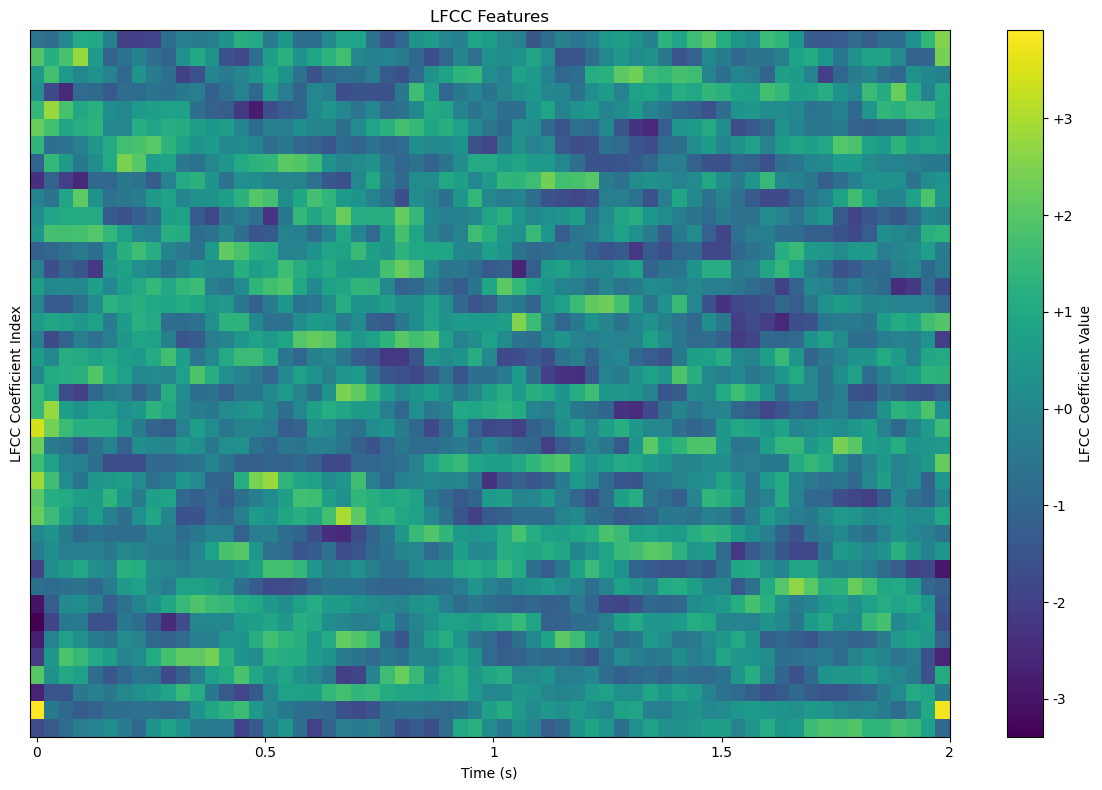

In [44]:
wav_file = r"E:\数据集\ShipEar\data_preprocessing\4_Frame_Windows_2s_50%\6__10_07_13_marDeCangas_Entra_18.wav"

waveform, original_sr = torchaudio.load(wav_file)

frame_length = 2048
hop_length = 512

target_sr = 16000
if original_sr != target_sr:
    resampler = torchaudio.transforms.Resample(original_sr, target_sr)
    waveform = resampler(waveform)
    
lfcc_features = extract_lfcc_features(waveform, target_sr, n_lfcc=41, do_cmvn=True, feature_type='lfcc')

plot_lfcc_features(lfcc_features, target_sr, None)

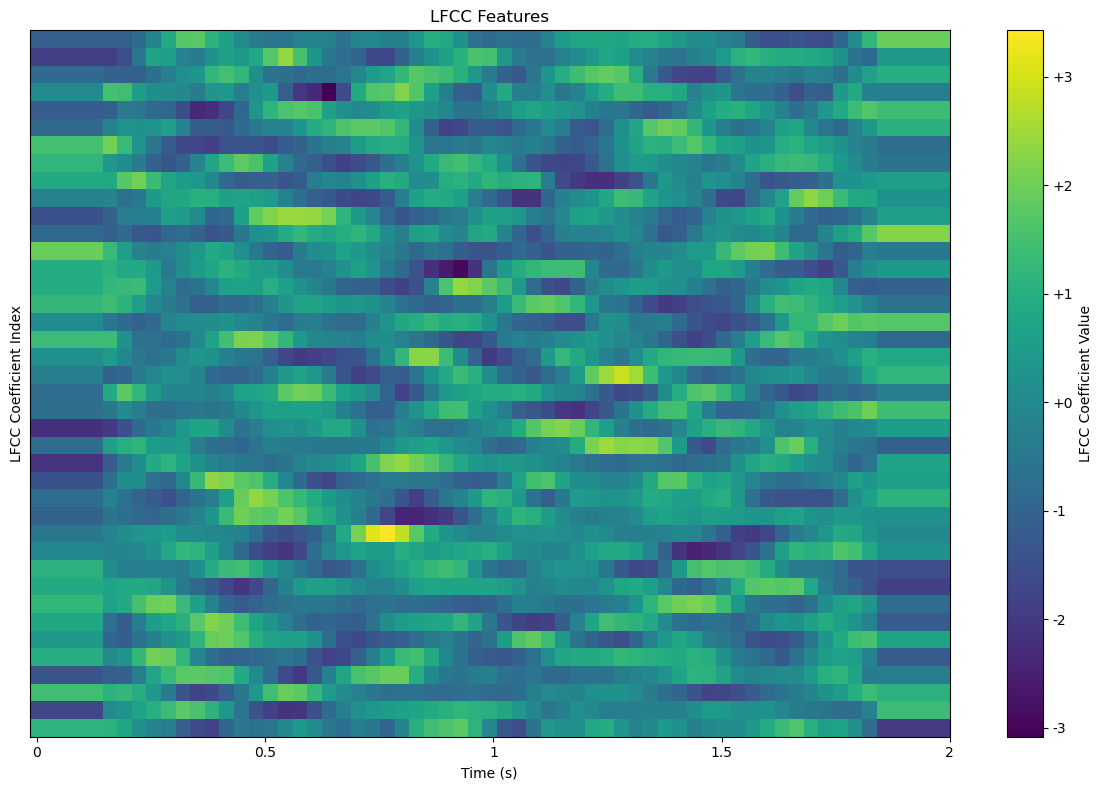

In [ ]:
lfcc_delta_features = extract_lfcc_features(waveform, target_sr, n_lfcc=41, do_cmvn=True, feature_type='delta')
plot_lfcc_features(lfcc_delta_features, target_sr, None)

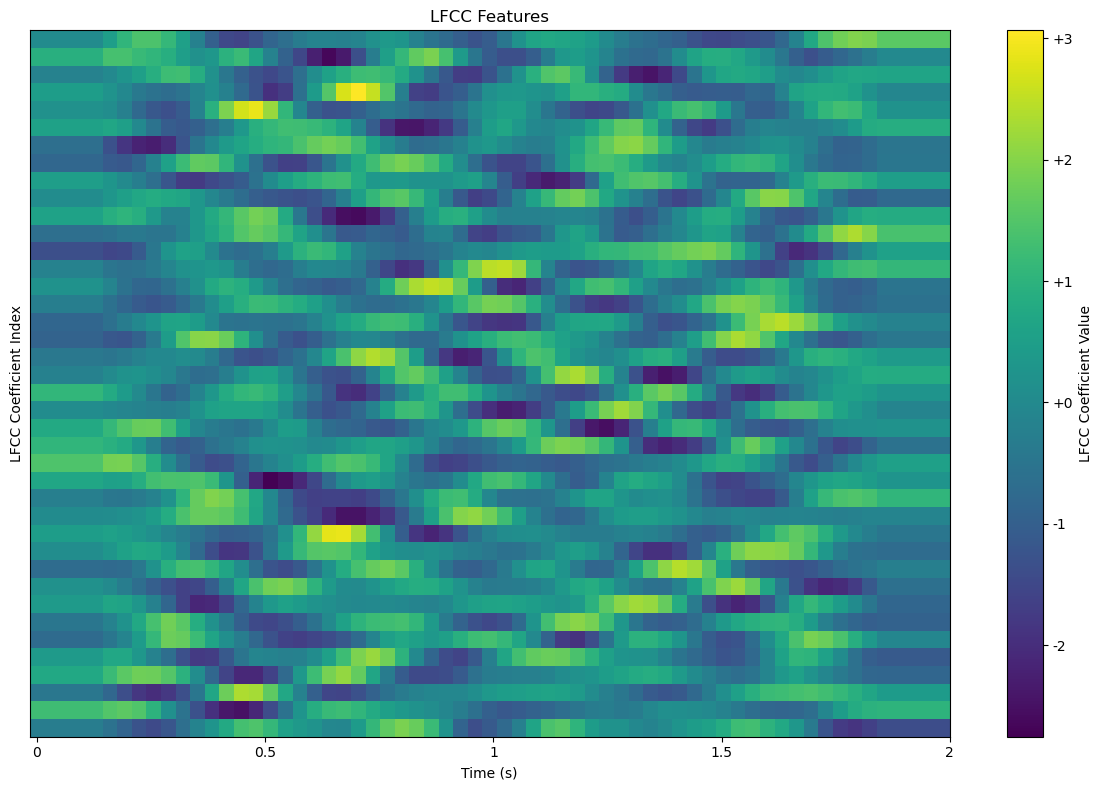

In [49]:
lfcc_delta_2_features = extract_lfcc_features(waveform, target_sr, n_lfcc=41, do_cmvn=True, feature_type='delta_2')
plot_lfcc_features(lfcc_delta_2_features, target_sr, None)

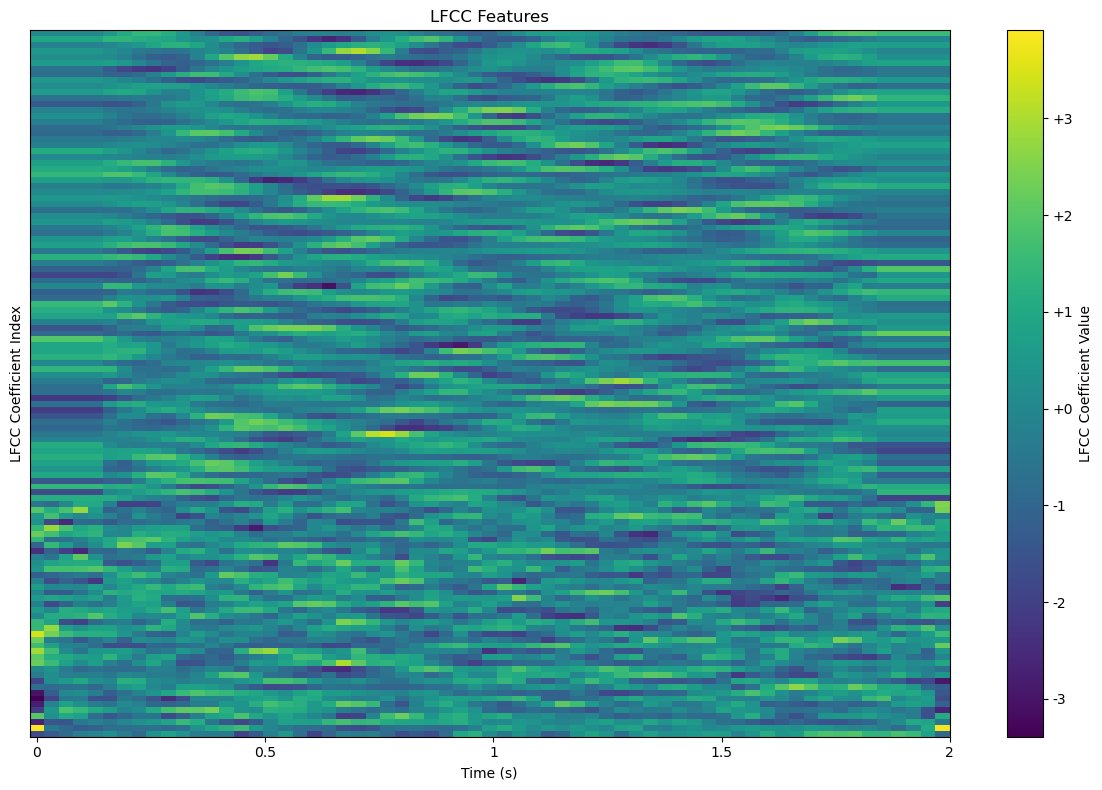

In [ ]:
lfcc_combined_features = extract_lfcc_features(waveform, target_sr, n_lfcc=41, do_cmvn=True, feature_type='combined')
plot_lfcc_features(lfcc_combined_features, target_sr, None)